In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/MyDrive/CS444/project')

Mounted at /content/gdrive


In [2]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
# from tensorflow.keras.metrics import Recall, Precision, AUC, BinaryAccuracy
# from tensorflow.python.keras.preprocessing.sequence import pad_sequences
# from deepctr.models import DeepFM
# from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names, VarLenSparseFeat
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 

In [3]:
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader
from autoint import BaseModel, EmbeddingLayer, BaseModelAutoInt
%load_ext autoreload
%autoreload 2

In [ ]:
torch.cuda.get_device_name()

'Tesla K80'

In [ ]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
plt.rc('font', **font)
sns.set(font_scale = 2)

def rating_map(x):
    if x > 3:
        return 1
    return 0

In [ ]:
def genre_encoding(x):
    genres = x.split('|')
    encoding = [0] * genre_size
    for g in genres:
        idx = genre2index[g]
        encoding[idx] = 1
    return encoding

In [ ]:
class MovieDataset:
    
    def __init__(self, data):
        self.X = np.array(data.drop(['Rating'], axis=1))
        self.y = np.array(data['Rating'])
        self.len = len(data)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return self.len 

In [ ]:
def test_classifier(test_loader, net, criterion):
    net.eval()
    losses = 0.0
    logits = torch.Tensor()
    ys = torch.Tensor()
    with torch.no_grad():
        for i, (X, y) in enumerate(test_loader):
            X, y = X.to(device), y.to(device)
            pred = net(X)
            loss = criterion(pred.flatten(), y.type(torch.float32))
            losses += loss.item()
            logits = torch.cat((logits, pred.flatten().cpu()))
            ys = torch.cat((ys, y.cpu()))
    auc = roc_auc_score(ys, logits)
    return losses / len(test_loader), auc

def train_classifier(train_loader, net, criterion, optimizer):
    net.train()
    loss_ = 0.0
    for i, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = net(X)
        loss = criterion(pred.flatten(), y.type(torch.float32))
        loss.backward()
        optimizer.step()
        loss_ += loss.item() 
        if (i + 1) % 100 == 0:
            auc = roc_auc_score(y.cpu(), pred.flatten().detach().cpu())
            print('Iter [{}/{}], Loss: {:.4f}, AUC: {:.4f}'.format(i + 1, len(train_loader), loss.item(), auc))
    return loss_ / len(train_loader)

def train_net(net, num_epochs, train_loader, test_loader, criterion, optimizer, test_frequency=10, save=False):
    train_losses = []
    train_aucs = []
    test_losses = []
    test_aucs = []

    for epoch in range(1,num_epochs+1):
        print('Epochs [{}/{}]'.format(epoch, num_epochs))
        train_loss = train_classifier(train_loader, net, criterion, optimizer)
        # train_losses.append(train_loss)
        if(epoch % test_frequency==0 or epoch==1):
            train_loss, train_auc = test_classifier(train_loader, net, criterion)
            test_loss, test_auc = test_classifier(test_loader, net, criterion)
            train_losses.append(train_loss)
            train_aucs.append(train_auc) 
            test_losses.append(test_loss)
            test_aucs.append(test_auc) 
            print('************************************************************************')
            print('Evaluating on test')
            print('Train loss: {:.4f}, Test loss: {:.4f}, Train AUC: {:.4f}, Test AUC: {:.4f}'.format(train_loss, test_loss, train_auc, test_auc))
            print('************************************************************************')
        if save and epoch % 10 == 0:
          torch.save(net.state_dict(), './checkpoints/detector_epoch_{}.pth'.format(epoch))
    return net, train_losses, train_aucs, test_losses, test_aucs

In [ ]:
ratings = pd.read_csv('./movielen/movie_len1M.txt', encoding='UTF-8')
ratings.drop(['Unnamed: 0'], axis=1, inplace=True)
# remove rating == 3
ratings = ratings.loc[ratings['Rating'] != 3]
ratings['Rating'] = ratings['Rating'].map(rating_map)
ratings.index = range(len(ratings))

In [ ]:
genre_list = ["Action", "Adventure", "Animation", 
               "Children's", "Comedy", "Crime",
               "Documentary", "Drama", "Fantasy",
               "Film-Noir", "Horror", "Musical", 
               "Mystery", "Romance", "Sci-Fi", 
               "Thriller", "War", "Western"]
genre_size = len(genre_list)
genre2index = dict()
for g, idx in zip(genre_list, range(genre_size)):
    genre2index[g] = idx 

In [ ]:
genres_mhot = list(ratings['Genres'].map(genre_encoding))
ratings = pd.concat((ratings, pd.DataFrame(genres_mhot)), axis=1)
ratings.drop(['Genres'], axis=1, inplace=True)

In [ ]:
sparse_features = ["UserID", "MovieID", "Gender", "Age", "Occupation"]
one_hot_size = []
# Label Encoding for sparse features
for feat in sparse_features:
    lbe = LabelEncoder()
    ratings[feat] = lbe.fit_transform(ratings[feat])
    one_hot_size.append(len(lbe.classes_))

In [ ]:
# idx_gt5 = (ratings['MovieID'].value_counts() > 5)
# movie_gt5 = ratings.loc[ratings['MovieID'].map(lambda x : idx_gt5[x])]
# movie_lt5 = ratings.loc[ratings['MovieID'].map(lambda x : ~idx_gt5[x])]
# test_size = int(len(ratings) * 0.1) 
train, test_val = train_test_split(ratings, test_size=0.2, random_state=444)
val, test = train_test_split(train, test_size=0.5, random_state=44)
# train = pd.concat((train, movie_lt5), axis=0)

In [ ]:
print(len(train))
print(len(val))
print(len(test))

591209
295604
295605


In [ ]:
print(len(ratings['UserID'].unique()))
print(len(train['UserID'].unique()))
print(len(test['UserID'].unique()))

6040
6040
6039


In [ ]:
print(len(ratings['MovieID'].unique()))
print(len(train['MovieID'].unique()))
print(len(test['MovieID'].unique()))

3668
3638
3543


In [ ]:
train_dataset = MovieDataset(train)
test_dataset = MovieDataset(test)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [ ]:
h=2
d_model=16
d_head=32
features=6
num_layer=1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
embedding_autoint = EmbeddingLayer(d_model, onehot_size=one_hot_size, genre_size=genre_size)
model_autoint = BaseModelAutoInt(h, d_model, d_head, features, num_layer=num_layer, dropout=0.0, inputproject=True, barchnorm=False)
net_autoint = nn.Sequential(embedding_autoint, model_autoint, nn.Sigmoid())
embedding_base = EmbeddingLayer(d_model, onehot_size=one_hot_size, genre_size=genre_size)
model_base = BaseModel(d_model, features)
net_base = nn.Sequential(embedding_base, model_base, nn.Sigmoid())

In [ ]:
net_base = net_base.to(device)
loss = nn.BCELoss(reduction='mean') 
optimizer = torch.optim.Adam(net_base.parameters(), lr=1e-4)
num_epochs = 30
test_frequency = 3

In [ ]:
net_base, train_losses_base, train_auc_base, test_losses_base, test_auc_base = train_net(net_base, num_epochs, train_loader, test_loader, loss, optimizer, test_frequency, save=False)

Epochs [1/30]
Iter [400/1155], Loss: 0.5640, AUC: 0.5325
Iter [800/1155], Loss: 0.5824, AUC: 0.4917
************************************************************************
Evaluating on test
Train loss: 0.5272, Test loss: 0.5260, Train AUC: 0.5586, Test AUC: 0.5565
************************************************************************
Epochs [2/30]
Iter [400/1155], Loss: 0.5182, AUC: 0.5341
Iter [800/1155], Loss: 0.5030, AUC: 0.6348
Epochs [3/30]
Iter [400/1155], Loss: 0.4774, AUC: 0.6745
Iter [800/1155], Loss: 0.4982, AUC: 0.6557
Epochs [4/30]
Iter [400/1155], Loss: 0.4830, AUC: 0.6605
Iter [800/1155], Loss: 0.4609, AUC: 0.7296
Epochs [5/30]
Iter [400/1155], Loss: 0.4703, AUC: 0.7166
Iter [800/1155], Loss: 0.4516, AUC: 0.7492
************************************************************************
Evaluating on test
Train loss: 0.4729, Test loss: 0.4727, Train AUC: 0.7225, Test AUC: 0.7197
************************************************************************
Epochs [6/30]
Iter [

In [ ]:
net_autoint = net_autoint.to(device)
loss = nn.BCELoss(reduction='mean') 
optimizer = torch.optim.Adam(net_autoint.parameters(), lr=1e-4)
num_epochs = 30
test_frequency = 3

In [ ]:
net_autoint, train_losses_autoint, train_auc_autoint, test_losses_autoint, test_auc_autoint = train_net(net_autoint, num_epochs, train_loader, test_loader, loss, optimizer, test_frequency, save=False)

Epochs [1/30]
Iter [400/1155], Loss: 0.5127, AUC: 0.5509
Iter [800/1155], Loss: 0.4895, AUC: 0.6516
************************************************************************
Evaluating on test
Train loss: 0.5042, Test loss: 0.5027, Train AUC: 0.6526, Test AUC: 0.6513
************************************************************************
Epochs [2/30]
Iter [400/1155], Loss: 0.4985, AUC: 0.6870
Iter [800/1155], Loss: 0.5408, AUC: 0.6380
Epochs [3/30]
Iter [400/1155], Loss: 0.4916, AUC: 0.7138
Iter [800/1155], Loss: 0.4669, AUC: 0.7127
Epochs [4/30]
Iter [400/1155], Loss: 0.5002, AUC: 0.7209
Iter [800/1155], Loss: 0.4463, AUC: 0.7631
Epochs [5/30]
Iter [400/1155], Loss: 0.4283, AUC: 0.7969
Iter [800/1155], Loss: 0.4497, AUC: 0.7498
************************************************************************
Evaluating on test
Train loss: 0.4421, Test loss: 0.4445, Train AUC: 0.7721, Test AUC: 0.7649
************************************************************************
Epochs [6/30]
Iter [

In [ ]:
h=2
d_model=16
d_head=32
features=6
num_layer=3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
embedding_autoint_3layer = EmbeddingLayer(d_model, onehot_size=one_hot_size, genre_size=genre_size)
model_autoint_3layer = BaseModelAutoInt(h, d_model, d_head, features, num_layer=num_layer, dropout=0.0, inputproject=True, barchnorm=False)
net_autoint_3layer = nn.Sequential(embedding_autoint_3layer, model_autoint_3layer, nn.Sigmoid())
# embedding_base = EmbeddingLayer(d_model, onehot_size=one_hot_size, genre_size=genre_size)
# model_base = BaseModel(d_model, features)
# net_base = nn.Sequential(embedding_base, model_base, nn.Sigmoid())

In [ ]:
net_autoint_3layer = net_autoint_3layer.to(device)
loss = nn.BCELoss(reduction='mean') 
optimizer = torch.optim.Adam(net_autoint_3layer.parameters(), lr=1e-4)
num_epochs = 30
test_frequency = 3

In [ ]:
net_autoint_3layer, train_losses_autoint_3layer, train_auc_autoint_3layer, test_losses_autoint_3layer, test_auc_autoint_3layer = train_net(net_autoint_3layer, num_epochs, train_loader, test_loader, loss, optimizer, test_frequency, save=False)

Epochs [1/30]
Iter [100/577], Loss: 0.5041, AUC: 0.5098
Iter [200/577], Loss: 0.4986, AUC: 0.5834
Iter [300/577], Loss: 0.5216, AUC: 0.6120
Iter [400/577], Loss: 0.5245, AUC: 0.6292
Iter [500/577], Loss: 0.5176, AUC: 0.6257
************************************************************************
Evaluating on test
Train loss: 0.5037, Test loss: 0.5038, Train AUC: 0.6592, Test AUC: 0.6595
************************************************************************
Epochs [2/30]
Iter [100/577], Loss: 0.4792, AUC: 0.6880
Iter [200/577], Loss: 0.4711, AUC: 0.7062
Iter [300/577], Loss: 0.4900, AUC: 0.7132
Iter [400/577], Loss: 0.4814, AUC: 0.7065
Iter [500/577], Loss: 0.4713, AUC: 0.7015
Epochs [3/30]
Iter [100/577], Loss: 0.4607, AUC: 0.7509
Iter [200/577], Loss: 0.4545, AUC: 0.7251
Iter [300/577], Loss: 0.4804, AUC: 0.7363
Iter [400/577], Loss: 0.4350, AUC: 0.7685
Iter [500/577], Loss: 0.4288, AUC: 0.7446
************************************************************************
Evaluating on t

In [ ]:
val_dataset = MovieDataset(val)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

In [ ]:
test_classifier(val_loader, net_autoint_3layer, loss)

(0.34028824307926797, 0.8776775382501301)

In [ ]:
# epoch_idx = list(range(1, num_epochs + 1))
test_idx = [1] + [x for x in range(1, num_epochs + 1) if x % test_frequency == 0]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

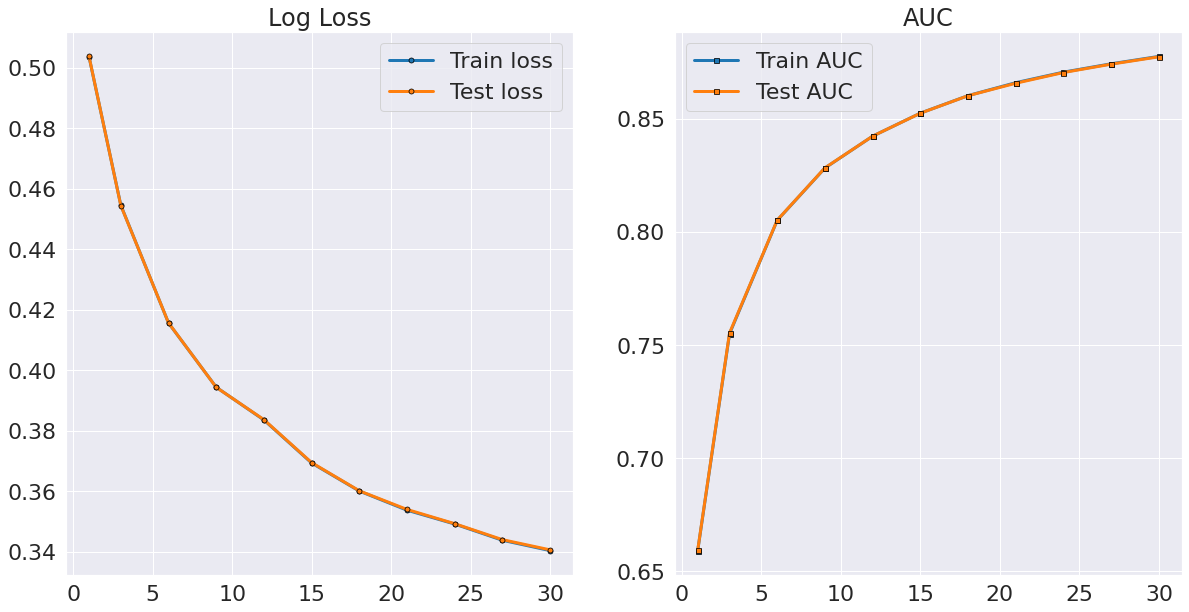

In [ ]:

# one
train_loss = train_losses_autoint_3layer
test_loss = test_losses_autoint_3layer
train_auc = train_auc_autoint_3layer
test_auc = test_auc_autoint_3layer

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ax1 = axs[0]
ax1.set_title('Log Loss')
sns.lineplot(test_idx, train_loss, ax=ax1, label='Train loss', color='tab:blue', marker='.', linewidth=3, markersize=10, markeredgecolor='black')
sns.lineplot(test_idx, test_loss, ax=ax1, label='Test loss', color='tab:orange', marker='.', linewidth=3, markersize=10, markeredgecolor='black')


ax3 = axs[1]
ax3.set_title('AUC')
sns.lineplot(test_idx, train_auc, ax=ax3, label='Train AUC', color='tab:blue', marker='s', linewidth=3, markersize=5, markeredgecolor='black')
sns.lineplot(test_idx, test_auc, ax=ax3, label='Test AUC', color='tab:orange', marker='s', linewidth=3, markersize=5, markeredgecolor='black')


## my

In [ ]:
h=2
d_model=64
d_head=32
features=6
num_layer=3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
embedding = EmbeddingLayer(d_model, onehot_size=one_hot_size, genre_size=genre_size)
model = BaseModelAutoInt(h, d_model, d_head, features, num_layer=num_layer, dropout=0.0, inputproject=False, barchnorm=False)
net = nn.Sequential(embedding, model, nn.Sigmoid())

In [ ]:
net = net.to(device)
loss = nn.BCELoss(reduction='mean') 
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
num_epochs = 30
test_frequency = 3

In [ ]:
net, train_losses, train_aucs, test_losses, test_aucs = train_net(net, num_epochs, train_loader, test_loader, loss, optimizer, test_frequency, save=False)

Epochs [1/30]
Iter [100/577], Loss: 0.5204, AUC: 0.5720
Iter [200/577], Loss: 0.5224, AUC: 0.5938
Iter [300/577], Loss: 0.4909, AUC: 0.6444
Iter [400/577], Loss: 0.4988, AUC: 0.6555
Iter [500/577], Loss: 0.5097, AUC: 0.6669
************************************************************************
Evaluating on test
Train loss: 0.4911, Test loss: 0.4914, Train AUC: 0.6881, Test AUC: 0.6877
************************************************************************
Epochs [2/30]
Iter [100/577], Loss: 0.4926, AUC: 0.6985
Iter [200/577], Loss: 0.4904, AUC: 0.6900
Iter [300/577], Loss: 0.4594, AUC: 0.7387
Iter [400/577], Loss: 0.4716, AUC: 0.7469
Iter [500/577], Loss: 0.4412, AUC: 0.7726
Epochs [3/30]
Iter [100/577], Loss: 0.4607, AUC: 0.7803
Iter [200/577], Loss: 0.4223, AUC: 0.8129
Iter [300/577], Loss: 0.4198, AUC: 0.7833
Iter [400/577], Loss: 0.4255, AUC: 0.7851
Iter [500/577], Loss: 0.4258, AUC: 0.7938
************************************************************************
Evaluating on t

In [ ]:
test_classifier(val_loader, net, loss)

(0.3239898744545181, 0.8903987488495848)

In [ ]:
test_idx

[1, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30]

In [ ]:
len(train_losses_autoint_3layer)

11

In [ ]:
# train_loss = train_losses_autoint_3layer
# test_loss = test_losses_autoint_3layer
# train_auc = train_auc_autoint_3layer
# test_auc = test_auc_autoint_3layer

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

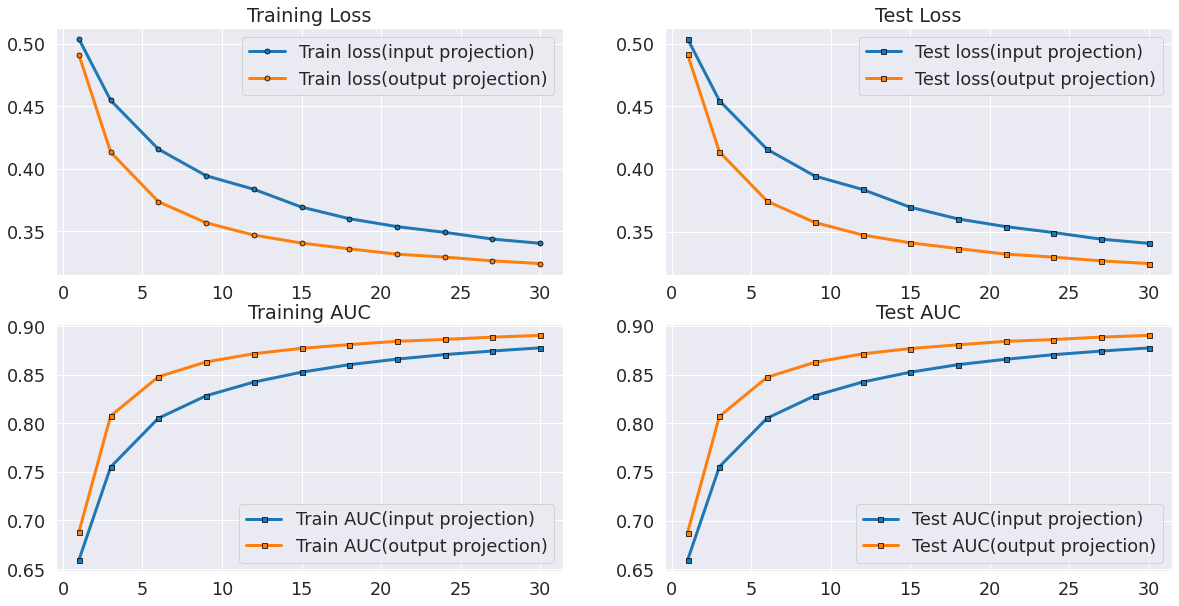

In [ ]:
# two
sns.set(font_scale = 1.6)
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
ax1 = axs[0][0]
ax1.set_title('Training Loss')
sns.lineplot(test_idx, train_losses_autoint_3layer, ax=ax1, label='Train loss(input projection)', color='tab:blue', marker='.', linewidth=3, markersize=10, markeredgecolor='black')
sns.lineplot(test_idx, train_losses, ax=ax1, label='Train loss(output projection)', color='tab:orange', marker='.', linewidth=3, markersize=10, markeredgecolor='black')

ax2 = axs[0][1]
ax2.set_title('Test Loss')
sns.lineplot(test_idx, test_losses_autoint_3layer, ax=ax2, label='Test loss(input projection)', color='tab:blue', marker='s', linewidth=3, markersize=5, markeredgecolor='black')
sns.lineplot(test_idx, test_losses, ax=ax2, label='Test loss(output projection)', color='tab:orange', marker='s', linewidth=3, markersize=5, markeredgecolor='black')

ax3 = axs[1][0]
ax3.set_title('Training AUC')
sns.lineplot(test_idx, train_auc_autoint_3layer, ax=ax3, label='Train AUC(input projection)', color='tab:blue', marker='s', linewidth=3, markersize=5, markeredgecolor='black')
sns.lineplot(test_idx, train_aucs, ax=ax3, label='Train AUC(output projection)', color='tab:orange', marker='s', linewidth=3, markersize=5, markeredgecolor='black')

ax4 = axs[1][1]
ax4.set_title('Test AUC')
sns.lineplot(test_idx, test_auc_autoint_3layer, ax=ax4, label='Test AUC(input projection)', color='tab:blue', marker='s', linewidth=3, markersize=5, markeredgecolor='black')
sns.lineplot(test_idx, test_aucs, ax=ax4, label='Test AUC(output projection)', color='tab:orange', marker='s', linewidth=3, markersize=5, markeredgecolor='black')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

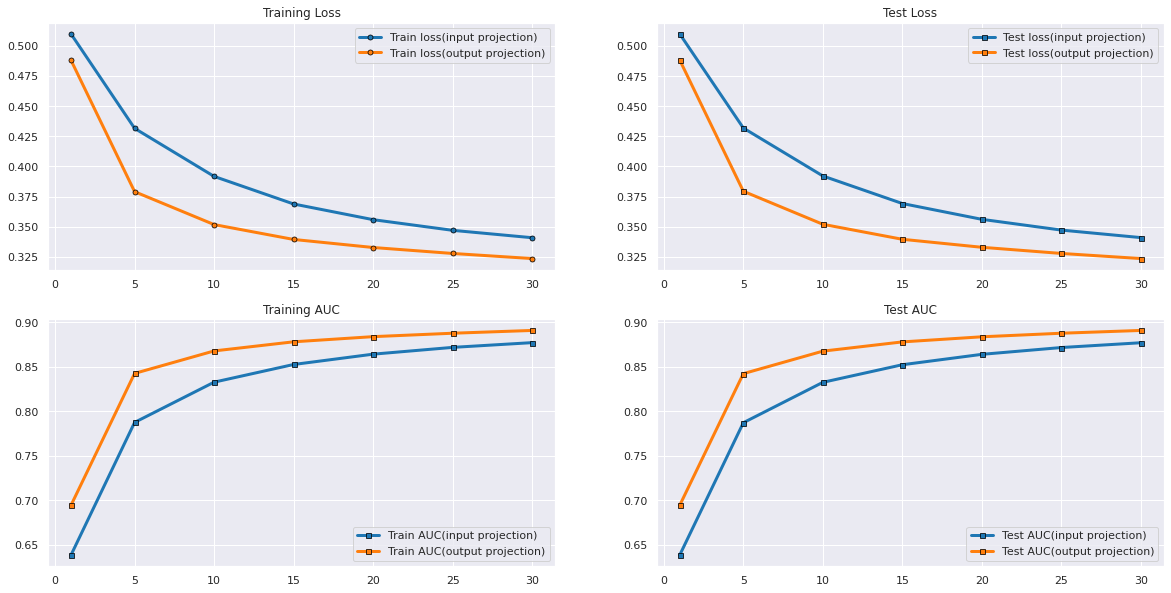

In [ ]:
# two
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
ax1 = axs[0][0]
ax1.set_title('Training Loss')
sns.lineplot(test_idx, train_losses_autoint_3layer, ax=ax1, label='Train loss(input projection)', color='tab:blue', marker='.', linewidth=3, markersize=10, markeredgecolor='black')
sns.lineplot(test_idx, train_losses, ax=ax1, label='Train loss(output projection)', color='tab:orange', marker='.', linewidth=3, markersize=10, markeredgecolor='black')

ax2 = axs[0][1]
ax2.set_title('Test Loss')
sns.lineplot(test_idx, test_losses_autoint_3layer, ax=ax2, label='Test loss(input projection)', color='tab:blue', marker='s', linewidth=3, markersize=5, markeredgecolor='black')
sns.lineplot(test_idx, test_losses, ax=ax2, label='Test loss(output projection)', color='tab:orange', marker='s', linewidth=3, markersize=5, markeredgecolor='black')

ax3 = axs[1][0]
ax3.set_title('Training AUC')
sns.lineplot(test_idx, train_auc_autoint_3layer, ax=ax3, label='Train AUC(input projection)', color='tab:blue', marker='s', linewidth=3, markersize=5, markeredgecolor='black')
sns.lineplot(test_idx, train_auc, ax=ax3, label='Train AUC(output projection)', color='tab:orange', marker='s', linewidth=3, markersize=5, markeredgecolor='black')

ax4 = axs[1][1]
ax4.set_title('Test AUC')
sns.lineplot(test_idx, test_auc_autoint_3layer, ax=ax4, label='Test AUC(input projection)', color='tab:blue', marker='s', linewidth=3, markersize=5, markeredgecolor='black')
sns.lineplot(test_idx, test_auc, ax=ax4, label='Test AUC(output projection)', color='tab:orange', marker='s', linewidth=3, markersize=5, markeredgecolor='black')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


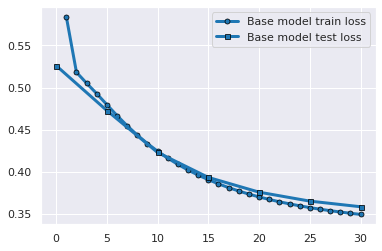

In [ ]:
sns.lineplot(epoch_idx, train_losses_base, label='Base model train loss', color='tab:blue', marker='.', linewidth=3, markersize=10, markeredgecolor='black')

sns.lineplot(test_idx, test_losses_base, label='Base model test loss', color='tab:blue', marker='s', linewidth=3, markersize=5, markeredgecolor='black')

In [ ]:
train_auc_base

[0.5586427359476857,
 0.7225067445487253,
 0.7990694016517319,
 0.8341433695374313,
 0.8528073588232346,
 0.8636167563571278,
 0.8703348926138461]

In [ ]:
test_auc_base

[0.5565046536358905,
 0.7197429698278623,
 0.7934032478905045,
 0.8268028697004672,
 0.8441688480225715,
 0.8540766603085981,
 0.8600594646543974]